In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

#tf.config.set_visible_devices([], 'GPU')
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
# works if vgg19.preprocess_input used for preprocessing
def deprocess_img(y):
  x = y.numpy().copy()
  # BGR
  # perform the inverse of the preprocessing step
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68

  # BGR -> RGB
  x = x[:, :, ::-1]

  x = np.clip(x, 0, 255).astype('uint8')
  return x

In [3]:
dim_size = 512

content_img = tf.io.read_file('tubingen.jpg')
content_img = tf.io.decode_jpeg(content_img) #H,W,C
content_img = tf.image.convert_image_dtype(content_img, tf.float32) * 255.0 # 0-255 -> 0-1
content_img = tf.image.resize(content_img,[dim_size,dim_size])
content_img = tf.keras.applications.vgg19.preprocess_input(content_img)

style_img = tf.io.read_file('starry_night.jpg')
style_img = tf.io.decode_jpeg(style_img) #H,W,C
style_img = tf.image.convert_image_dtype(style_img, tf.float32) * 255.0 # 0-255 -> 0-1
style_img = tf.image.resize(style_img,[dim_size,dim_size])
style_img = tf.keras.applications.vgg19.preprocess_input(style_img)

Metal device set to: AMD Radeon Pro 560X

systemMemory: 16.00 GB
maxCacheSize: 2.00 GB



2022-03-01 18:33:51.186498: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-01 18:33:51.187062: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-01 18:33:51.187375: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

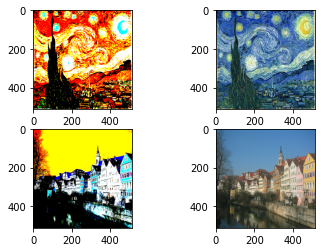

In [4]:
plt.figure()
_, ax = plt.subplots(2,2)

ax[0,0].imshow(style_img)
ax[0,1].imshow(deprocess_img(style_img))

ax[1,0].imshow(content_img)
ax[1,1].imshow(deprocess_img(content_img))

In [5]:
vgg19 = tf.keras.applications.VGG19(include_top=False,input_shape=style_img.shape)
vgg19.trainable = False

## normalize the pretrained weights here!

In [6]:
content_layers = ['block4_conv2']
style_layers = ['block1_conv1','block2_conv1','block3_conv1','block4_conv1','block5_conv1']

content_outputs = []
style_outputs = []
for layer in vgg19.layers:
    if layer.name in content_layers:
        content_outputs.append(layer.output)
    if layer.name in style_layers:
        style_outputs.append(layer.output)

In [7]:
model_content = tf.keras.Model(inputs = vgg19.input, outputs= content_outputs)
model_style = tf.keras.Model(inputs = vgg19.input, outputs= style_outputs)


# adding batch axis
content_img = content_img[tf.newaxis,...]
style_img = style_img[tf.newaxis,...]

content_repr = model_content(content_img)
style_repr = model_style(style_img)

In [8]:
## ABOVE IS CONSTANT FROM NOW ON!

In [9]:
def content_loss(content_repr,current_content_repr):
    channel_size = content_repr.shape[-1]
    f = tf.reshape(content_repr,[1,-1,channel_size])
    p = tf.reshape(current_content_repr,[1,-1,channel_size])

    return 0.5 * tf.reduce_sum(tf.square(f - p))

def style_loss_layer(temp_style_repr,temp_current_style_repr):
    channel_size = temp_style_repr.shape[-1]
    temp_style_repr = tf.reshape(temp_style_repr,[1,-1,channel_size])
    _,ml,nl = temp_style_repr.shape
    temp_current_style_repr = tf.reshape(temp_current_style_repr,[1,-1,channel_size])

    g= tf.transpose(temp_style_repr,perm=[0,2,1]) @ temp_style_repr
    a= tf.transpose(temp_current_style_repr,perm=[0,2,1]) @ temp_current_style_repr

    return (1/(4 * ml**2 * nl**2)) * tf.reduce_sum(tf.square(g - a))

def style_loss(style_repr,current_style_repr):
    total = 0
    for idx in range(len(style_repr)):
        total += (1/len(style_repr)) * style_loss_layer(style_repr[idx],current_style_repr[idx])

    return total


In [10]:
# DONE
# check for any mathematical bugs -done-
# reducing loss via setting alpha and beta so small -done, not working-
# do it on colab -done-

# TO DO
# 1- using style repr, reconstruct style representations(fig1,style rec)
# do you get style and content reconstructions for style and content images?

# 2- normalize content and style images [-1,1]. use torch or tf initialization? (cancel noise initialization)


# EXTRAS
# max pool -> avg pool in vgg
# weight normalization



# after all of your trials you can consult on tutorials!
# eth logo

In [11]:
# training loop

optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.2)

# initialize trainable noise
n = tf.random.normal(shape = style_img.shape)
n = ((n - np.min(n))/np.max(n)) * 255.
n = tf.keras.applications.vgg19.preprocess_input(n)
noise_img= tf.Variable(initial_value=n)

# initialize with content image
#noise_img= tf.Variable(initial_value=content_img)

model_noise = tf.keras.Model(inputs = vgg19.input, outputs= style_outputs + content_outputs)

beta = 1e-7
alpha = beta * 1e-3

EPOCHS = 2000

for e in range(EPOCHS):

    # training loop
    with tf.GradientTape() as tape:

        noise_repr = model_noise(noise_img)
        current_content_repr = noise_repr[-1]
        current_style_repr = noise_repr[:-1]
        loss_c = alpha * content_loss(content_repr,current_content_repr)
        loss_s = beta * style_loss(style_repr,current_style_repr)
        loss = loss_s + loss_c
    
    gradients = tape.gradient(loss,[noise_img])
    optimizer.apply_gradients(zip(gradients, [noise_img]))
        
    if e%100==0:
        print(f'epoch: {e}, content_loss: {loss_c.numpy()}, style_loss: {loss_s.numpy()}')
        matplotlib.image.imsave('created.jpg', deprocess_img(noise_img[0,...]))


epoch: 0, style_loss: 1041.4013671875
epoch: 100, style_loss: 1041.4013671875
epoch: 200, style_loss: 1041.4013671875
epoch: 300, style_loss: 1041.4013671875
epoch: 400, style_loss: 1041.4013671875
epoch: 500, style_loss: 1041.4013671875
epoch: 600, style_loss: 1041.4013671875
epoch: 700, style_loss: 1041.4013671875


KeyboardInterrupt: 